<a href="https://colab.research.google.com/github/kaitken17/colab_stuff/blob/master/syn_data_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_text
!python -m pip install git+https://github.com/nirum/jetpack 

print('Jetpack version:', jetpack.__version__)

In [3]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers, stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')
import renn

sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/')
import synthetic.synthetic_data as syn
import synthetic.training as syn_train
import synthetic.analysis as syn_an

import jetpack

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)737280/45929032 bytes (1.6%)2048000/45929032 bytes (4.5%)3981312/45929032 bytes (8.7%)6766592/45929032 bytes (14.7%)10657792/45929032 bytes (23.2%)14909440/45929032 bytes (32.5%)18972672/45929032 bytes (41.3%)23150592/45929032 bytes (50.4%)27279360/45929032 bytes (59.4%)31440896/45929032 bytes (68.5%)35586048/45929032 bytes (77.5%)39755776/45929032 bytes (86.6%)4377804

In [26]:
# Reload modules if changes have been made to them
from importlib import reload

reload(syn)
reload(syn_train)
reload(syn_an)

<module 'synthetic.analysis' from '/content/drive/My Drive/ml_research/fixedpoints_nlp/synthetic/analysis.py'>

### Plotting Stuff

In [7]:
from matplotlib import rcParams

rcParams.update({
    'lines.linewidth': 1.5,
    'lines.linestyle': '-',
    'lines.marker': None,
    'lines.markeredgewidth': 0.,
    'lines.markersize': 6.,
    'lines.antialiased': True,
    'lines.solid_joinstyle': 'round',
    'lines.solid_capstyle': 'round',

    'patch.linewidth': 1.,
    'patch.facecolor': '#cccccc',
    'patch.edgecolor': 'none',
    'patch.antialiased': True,

    'font.size': 10,
    'text.usetex': False,
    'mathtext.default': 'regular',

    'axes.linewidth': 1.0,
    'axes.grid': False,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'axes.labelweight': 'normal',
    'axes.axisbelow': True,
    'axes.formatter.use_mathtext': False,
    'axes.xmargin': 0.,
    'axes.ymargin': 0.,
    'polaraxes.grid': True,

    'xtick.direction': 'out',
    'xtick.labelsize': 10.,
    'xtick.major.size': 4.,
    'xtick.minor.size': 2.,
    'xtick.major.width': 1.,
    'xtick.minor.width': 1.,

    'ytick.direction': 'out',
    'ytick.labelsize': 10.,
    'ytick.major.size': 4.,
    'ytick.minor.size': 2.,
    'ytick.major.width': 1.,
    'ytick.minor.width': 1.,

    'grid.linestyle': 'dotted',
    'grid.alpha': 0.5,
    'grid.linewidth': 1.0,

    'legend.frameon': False,
    'legend.fancybox': True,
    'legend.fontsize': 10.,
    'legend.loc': 'best',

    'figure.figsize': (5, 3),
    'figure.dpi': 300,
    'figure.autolayout': True,

    'image.cmap': 'viridis',
    'image.interpolation': None,
    'image.aspect': 'equal',

    'savefig.format': 'pdf',
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'pdf.fonttype': 42,
})

In [26]:
cat = [jetpack.colors.blue.v6, jetpack.colors.red.v6, jetpack.colors.green.v6, jetpack.colors.orange.v6]
cat_light = [jetpack.colors.blue.v3, jetpack.colors.red.v3, jetpack.colors.green.v3, jetpack.colors.orange.v3]

ordered = list(jetpack.colors.cmap_colors('RdYlGn', 5))
ordered[2] = jetpack.colors.yellow.v5

#### 3-Class Unordered Plots

In [9]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_3classrgb_uniformscore_noRO_l2is5e-4_2.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


In [10]:
cell = syn_an.build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_hs_trials = 600
pc_dims = 5

syn_data_test = syn.generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

readout = readout_params.T
# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', syn_an.participation_ratio_vector(pca_full.explained_variance_))
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)

# The initial state.
h0 = cell.get_initial_state(rnn_params)

word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/4*jnp.ones(rnn_specs['input_size'])

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=5e-4, steps=range(10000))

# PCA on fixed points
pca_full_fp = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full_fp.fit_transform(fixed_points)
explained_var = pca_full_fp.explained_variance_ratio_
total_exvar_fp = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_fp.append(np.sum(explained_var[:i+1]))

# Filters out non-unique points for flows
unique_tol = 0.5
do_print = True
points_unique, unique_kidxs = syn_an.keep_unique_fixed_points(pts, unique_tol, do_print)
steps = 1

words = ['kinda0', 'kinda1', 'kinda2', 'the']
points_reduced = points_unique
points_final_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = syn.wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

Using GRU cell
Looking for num per class: [200. 200. 200.]
Sythentic data generated in: 0.56 sec. Autobalanced: True. Uniform score: True
(14700, 128)
Copy this: PCA: [0.50123316 0.47082075 0.01506039 0.00533679 0.00312875] PR: 2.1133831609346165
Category 0 states: 200
Category 1 states: 200
Category 2 states: 200
Using word tensor: [0.25 0.25 0.25 0.25]
    Kept 462/14700 unique fixed points with uniqueness tolerance 0.500000.


In [ ]:
base_path_save = '/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/data/3class_unordered.pickle'
save_data = {
    'states': states,
    'readout': readout,
}
with open(base_path_save, 'wb') as save_file:
  pickle.dump(save_data, save_file, protocol=pickle.HIGHEST_PROTOCOL)
print('Data Saved')

In [72]:
# Loads in dimensionality data
# Loads data
with open('/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/data/hs_dims_trials0to4_5e-4.pickle', 'rb') as load_file:
  load_data_hs1 = pickle.load(load_file)
with open('/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/data/hs_dims_trials5to9_5e-4.pickle', 'rb') as load_file:
  load_data_hs2 = pickle.load(load_file)

prhs_avg = np.mean(np.concatenate((load_data_hs1['prs'], load_data_hs2['prs']), axis=1), axis=1)
local_prhs_avg = np.mean(np.concatenate((load_data_hs1['local_prs'], load_data_hs2['local_prs']), axis=1), axis=1)
ve_varhs_avg = np.mean(np.concatenate((load_data_hs1['ve_threshold_var'], load_data_hs2['ve_threshold_var']), axis=1), axis=1)
ve_90hs_avg = np.mean(np.concatenate((load_data_hs1['ve_threshold_90'], load_data_hs2['ve_threshold_90']), axis=1), axis=1)
ve_95hs_avg = np.mean(np.concatenate((load_data_hs1['ve_threshold_95'], load_data_hs2['ve_threshold_95']), axis=1), axis=1)
mkhs_avg = np.mean(np.concatenate((load_data_hs1['m_k_vals'], load_data_hs2['m_k_vals']), axis=2), axis=2)
cdhs_avg = np.mean(np.concatenate((load_data_hs1['corr_dim_vals'], load_data_hs2['corr_dim_vals']), axis=1), axis=1)

# Loads data
with open('/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/data/fp_dims_trials0to4_5e-4.pickle', 'rb') as load_file:
  load_data_fp1 = pickle.load(load_file)
with open('/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/data/fp_dims_trials5to9_5e-4.pickle', 'rb') as load_file:
  load_data_fp2 = pickle.load(load_file)

prfp_avg = np.mean(np.concatenate((load_data_fp1['prs'], load_data_fp2['prs']), axis=1), axis=1)
local_prfp_avg = np.mean(np.concatenate((load_data_fp1['local_prs'], load_data_fp2['local_prs']), axis=1), axis=1)
ve_varfp_avg = np.mean(np.concatenate((load_data_fp1['ve_threshold_var'], load_data_fp2['ve_threshold_var']), axis=1), axis=1)
ve_90fp_avg = np.mean(np.concatenate((load_data_fp1['ve_threshold_90'], load_data_fp2['ve_threshold_90']), axis=1), axis=1)
ve_95fp_avg = np.mean(np.concatenate((load_data_fp1['ve_threshold_95'], load_data_fp2['ve_threshold_95']), axis=1), axis=1)
mkfp_avg = np.mean(np.concatenate((load_data_fp1['m_k_vals'], load_data_fp2['m_k_vals']), axis=2), axis=2)
cdfp_avg = np.mean(np.concatenate((load_data_fp1['corr_dim_vals'], load_data_fp2['corr_dim_vals']), axis=1), axis=1)

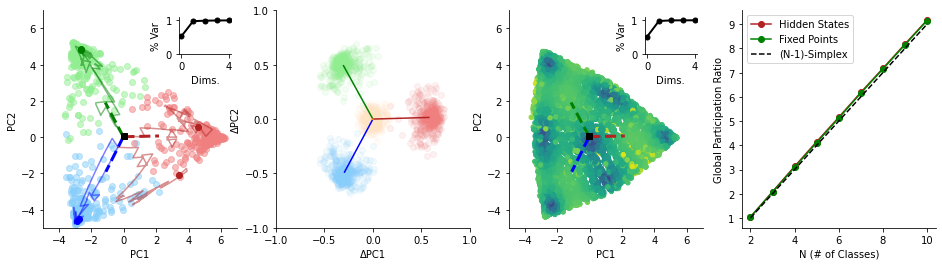

In [75]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(141);
ax2 = fig.add_subplot(143);
ax3 = fig.add_subplot(142);
ax4 = fig.add_subplot(144);

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['g', 'b', 'firebrick', 'orange', 'y', 'm', 'cyan', 'brown']
state_colors_light = ['lightgreen', 'lightskyblue', 'lightcoral', 'bisque']

n_to_plot = 5

##### Hidden States #####

for i in range(len(toy_params['sentiments'])):
  for state_idx in range(len(states[i])): # Plots grey final states
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors_light[i], marker='o', alpha=0.5)
  for state_idx in range(6,8): # Only plots 2 for each color
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = state_colors[i], marker=None, alpha=0.5)
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors[i], marker='o', alpha=1.0)

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax1.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'dashed', label='RO'+str(i))
  ax2.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'dashed', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 1
iax1 = plt.axes([0,0,1,1])
iax1.set_axes_locator(InsetPosition(ax1, [0.7,0.8,0.27,0.17]))
iax1.plot(range(n_to_plot), total_exvar_hs[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax1.set_ylim(0,1.1)
iax1.set_xlabel('Dims.')
iax1.set_ylabel('% Var')
iax1.set_xticks([0,n_to_plot-1])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
ax2.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.7,0.8,0.27,0.17]))
iax2.plot(range(n_to_plot), total_exvar_fp[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax2.set_ylim(0,1.1)
iax2.set_xlabel('Dims.')
iax2.set_ylabel('% Var')
iax2.set_xticks([0,n_to_plot-1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

##### Flows #####

# ax3.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='lightgrey', alpha=1.0)

# Inset 3
# iax3 = plt.axes([0,0,1,1.0001])
# iax3.set_axes_locator(InsetPosition(ax3, [0.7,0.7,0.27,0.27]))

for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 1:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=state_colors[word_idx])
  ax3.scatter(defs1, defs2, color=state_colors_light[word_idx], alpha=0.1)
  ax3.set_xlim(-1,1)
  ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_yticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_ylim(-1,1)
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

# Dimensionality plot
class_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]

ax4.plot(class_sizes, prhs_avg, label='Hidden States', marker='o', c='firebrick')
ax4.plot(class_sizes, prfp_avg, label='Fixed Points', marker='o', c='g')

ax4.plot(class_sizes, [class_val-1 for class_val in class_sizes], c='k', linestyle='dashed', label='(N-1)-Simplex')
ax4.set_xlabel('N (# of Classes)')
ax4.set_ylabel('Global Participation Ratio')
ax4.legend()

main_axs = [ax1, ax2]
x_lims = (-5, 7)
y_lims = (-5, 7)
for axis in main_axs:
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

all_axs = [ax1, ax2, ax3, ax4, iax1, iax2]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)


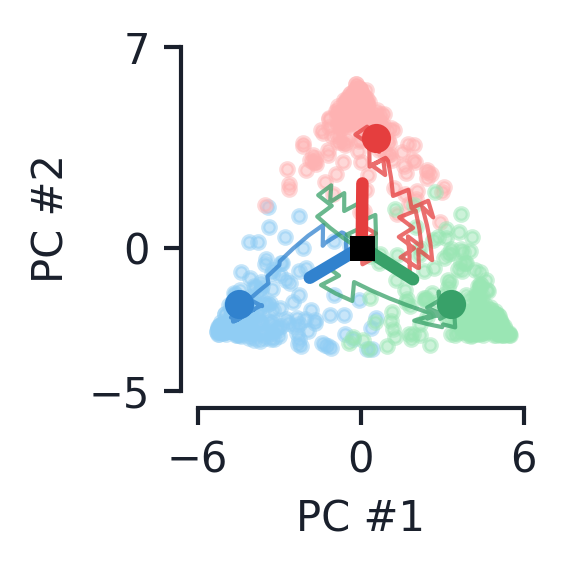

In [65]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(2, 2))
ax1 = fig.add_subplot(111)

##### Hidden States #####

for i in range(len(toy_params['sentiments'])):
  for state_idx in range(len(states[i])): # Plots grey final states
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = cat_light[i], marker='.', alpha=0.5)
  for state_idx in range(3,4): # Only plots 1 trajetory for each color
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = cat[i], marker=None, linewidth=1, alpha=0.75)
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = cat[i], marker='o', alpha=1.0)

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax1.plot(x_ro, y_ro, cat[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

ax1.set_xlim(-6, 6)
ax1.set_xticks([-6, 0, 6])
ax1.set_ylim(-5, 7)
ax1.set_yticks([-5, 0, 7])
ax1.set_xlabel('PC #1')
ax1.set_ylabel('PC #2')

jetpack.breathe(ax=ax1)

fig.savefig('/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/3unordered_syn_hs.pdf')


  func(*args, **kwargs)

  fig.canvas.print_figure(bytes_io, **kw)



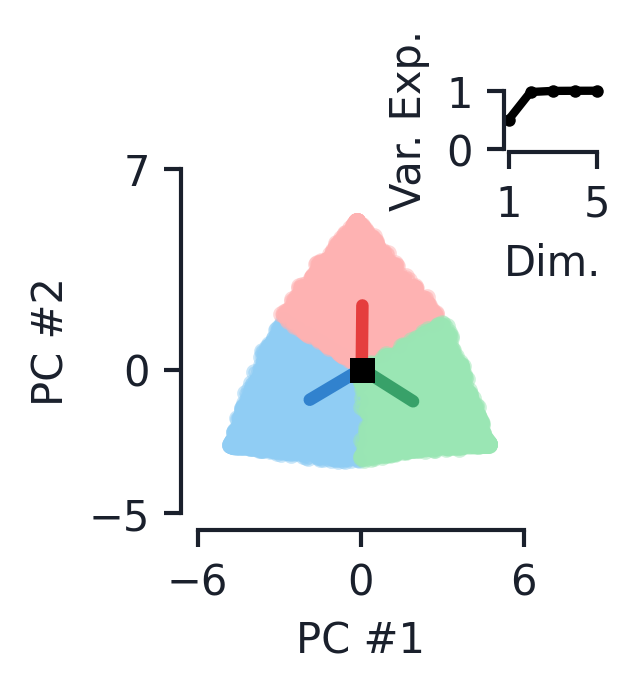

In [58]:
pc1 = 0
pc2 = 1

n_to_plot = 5

fig = plt.figure(figsize=(2, 2))
ax2 = fig.add_subplot(111)

fp_states = []
for i in range(len(toy_params['sentiments'])):
  fp_states.append([fp for fp in fixed_points if np.argmax(np.matmul(readout, fp)) == i])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
for i in range(len(fp_states)):
  pca_fps = pca.transform(np.vstack(fp_states[i])).T
  ax2.scatter(pca_fps[pc1], pca_fps[pc2], marker='.', color=cat_light[i], alpha=0.5)

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax2.plot(x_ro, y_ro, cat[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.9,1.0,0.27,0.17]))
iax2.plot(range(1,n_to_plot+1), total_exvar_fp[:n_to_plot], color='black', marker='.', linewidth=2, clip_on=False)
iax2.set_ylim(0,1.0)
iax2.set_xlim(1,n_to_plot)
iax2.set_xlabel('Dim.')
iax2.set_ylabel('Var. Exp.')
iax2.set_xticks([1,n_to_plot])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

ax2.set_xlim(-6, 6)
ax2.set_xticks([-6, 0, 6])
ax2.set_ylim(-5, 7)
ax2.set_yticks([-5, 0, 7])
ax2.set_xlabel('PC #1')
ax2.set_ylabel('PC #2')

jetpack.breathe(ax=ax2)
jetpack.breathe(ax=iax2)

fig.savefig('/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/3unordered_syn_fp.pdf')

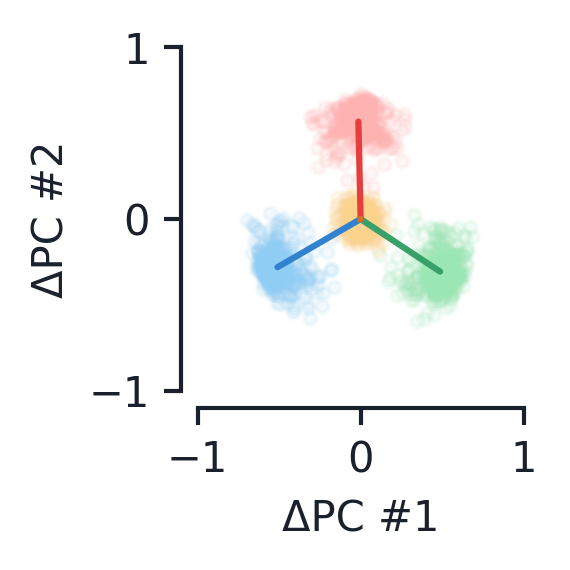

In [59]:
##### Flows #####

fig = plt.figure(figsize=(2, 2))
ax3 = fig.add_subplot(111)

for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 1:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=cat[word_idx])
  ax3.scatter(defs1, defs2, color=cat_light[word_idx], alpha=0.1, marker='.')

ax3.set_xlim(-1,1)
ax3.set_xticks([-1, 0, 1])
ax3.set_yticks([-1, 0, 1])
ax3.set_ylim(-1,1)
ax3.set_xlabel('ΔPC #1')
ax3.set_ylabel('ΔPC #2')

jetpack.breathe(ax=ax3)

fig.savefig('/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/3unordered_syn_def.pdf')

In [ ]:
take_every = 5
n_top = 8
n_fp = len(fixed_points)
print('Evaluating {} fixed points.'.format(n_fp))
max_evals_mag = np.zeros((int(n_fp/take_every), n_top))
max_evals = np.zeros((int(n_fp/take_every), n_top))
pc_dim_val = np.zeros(int(n_fp/take_every))

# input_word = jnp.zeros(rnn_specs['input_size'])
input_word = 1/4*jnp.ones(rnn_specs['input_size'])

for i in tqdm(range(0, int(n_fp/take_every))):
  fp = fixed_points[i*take_every]
  jac = jax.device_get(cell.rec_jac(rnn_params, input_word, fp))
  _, E, _ = renn.eigsorted(jac)
  Emags = np.absolute(E)
  rE = np.real(E)
  rE.sort()
  Emags.sort()
  max_evals_mag[i] = Emags[-n_top:]
  max_evals[i] = rE[-n_top:]

Evaluating 14700 fixed points.


KeyboardInterrupt: ignored

In [ ]:
tc_means = np.zeros((n_top,)) 
tc_medians = np.zeros((n_top,))
tc_75perc = np.zeros((n_top,)) 
tc_25perc = np.zeros((n_top,)) 
tc_err_bars = np.zeros((2, n_top)) 
for i in range(n_top):
  tcs = np.abs(1/np.log(max_evals_mag[:,n_top-1-i]))
  tc_means[i] = np.mean(tcs)
  tc_medians[i] = np.median(tcs)
  tc_75perc[i] = np.percentile(tcs, 90) 
  tc_25perc[i] = np.percentile(tcs, 10)
  tc_err_bars[0,i] = tc_medians[i]-tc_25perc[i]
  tc_err_bars[1,i] = tc_75perc[i] - tc_medians[i] 


plt.figure()
plt.errorbar(np.asarray(range(n_top))+1, tc_medians, yerr=tc_err_bars, xerr=None, uplims=True, lolims=True, marker='o', color='k')
plt.axhline(50, color='k', linestyle='dashed')
plt.xlabel('Top Magnitude Eigenvalue')
plt.ylabel('|Time Constant|')

In [ ]:
# Tests data shuffling
n_shuf = 500
syn_data_test_raw = syn.generate_data(n_shuf, toy_params, rnn_specs['output_size'], auto_balance=False, jnp_arrays=False)

syn_data_test = {
  'inputs': jnp.asarray(syn_data_test_raw['inputs']),  # Phrase tensors: dataset_size x phrase_len x in_dim
  'labels': jnp.asarray(syn_data_test_raw['labels']), # Sentiment tensors: dataset_size x phrase_len x out_dim
  'index': jnp.asarray(syn_data_test_raw['index'], dtype=jnp.int32), # Target mask: list of integers up to phrase_len
}
hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)

syn_data_input_shuf = np.copy(syn_data_test_raw['inputs'])
for phrase_idx in range(syn_data_test_raw['inputs'].shape[0]):
  np.random.shuffle(syn_data_input_shuf[phrase_idx])

syn_data_test_shuf = {
  'inputs': jnp.asarray(syn_data_input_shuf),  # Phrase tensors: dataset_size x phrase_len x in_dim
  'labels': jnp.asarray(syn_data_test_raw['labels']), # Sentiment tensors: dataset_size x phrase_len x out_dim
  'index': jnp.asarray(syn_data_test_raw['index'], dtype=jnp.int32), # Target mask: list of integers up to phrase_len
}
hs_shuf = syn_an.rnn_states(cell, syn_data_test_shuf, rnn_params, only_final=False)

Sythentic data generated in: 0.45 sec. Autobalanced: False. Uniform score: True


Average diff: 0.16784194732038304
Class diff: 0.98


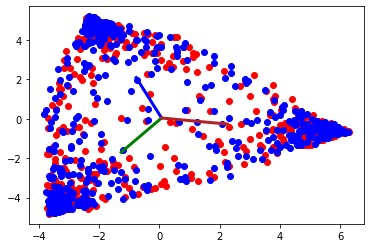

In [ ]:
pc0_coords = []
pc1_coords = []
pc0_shuf_coords = []
pc1_shuf_coords = []
norm_diff = np.zeros((n_shuf))
class_diff = np.zeros((n_shuf))

for i in range(n_shuf):
  pca_hs = pca.transform(hs[i])[48]
  pca_hs_shuf = pca.transform(hs_shuf[i])[48]
  pc0_coords.append(pca_hs[0])
  pc1_coords.append(pca_hs[1])
  pc0_shuf_coords.append(pca_hs_shuf[0])
  pc1_shuf_coords.append(pca_hs_shuf[1])

  norm_diff[i] = np.linalg.norm(hs[i][48] - hs_shuf[i][48])/np.linalg.norm(hs[i][48])
  
  class_diff[i] = np.argmax(np.dot(readout, hs[i][48])) == np.argmax(np.dot(readout, hs_shuf[i][48])) 


print('Average diff:', np.mean(norm_diff))
print('Class diff:', np.mean(class_diff))

plt.figure()
plt.scatter(pc0_coords, pc1_coords, c='r')
plt.scatter(pc0_shuf_coords, pc1_shuf_coords, c='b')

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))

#### 3-Class Ordered Plots

In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_3class_uniformscore_noRO_l2is1e-2.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


In [ ]:
cell = syn_an.build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_hs_trials = 600
pc_dims = 5

syn_data_test = syn.generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

readout = readout_params.T

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', syn_an.participation_ratio_vector(pca_full.explained_variance_))
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)

# The initial state.
h0 = cell.get_initial_state(rnn_params)

word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/3*jnp.ones(rnn_specs['input_size'])

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=3e-3, steps=range(10000))

# PCA on fixed points
pca_full_fp = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full_fp.fit_transform(fixed_points)
explained_var = pca_full_fp.explained_variance_ratio_
total_exvar_fp = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_fp.append(np.sum(explained_var[:i+1]))

# Filters out non-unique points for flows
unique_tol = 0.1
do_print = True
points_unique, unique_kidxs = syn_an.keep_unique_fixed_points(pts, unique_tol, do_print)
steps = 1

words = ['bad', 'the', 'good']
points_reduced = points_unique
points_final_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = syn.wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

Using GRU cell
Looking for num per class: [200. 200. 200.]
Sythentic data generated in: 0.07 sec. Autobalanced: True. Uniform score: True
(14700, 128)
Copy this: PCA: [8.6531651e-01 1.3445841e-01 1.5244327e-04 5.9584585e-05 1.0289375e-05] PR: 1.3040329894309335
Category 0 states: 200
Category 1 states: 200
Category 2 states: 200
Using word tensor: [0.33333334 0.33333334 0.33333334]
    Kept 979/14700 unique fixed points with uniqueness tolerance 0.100000.


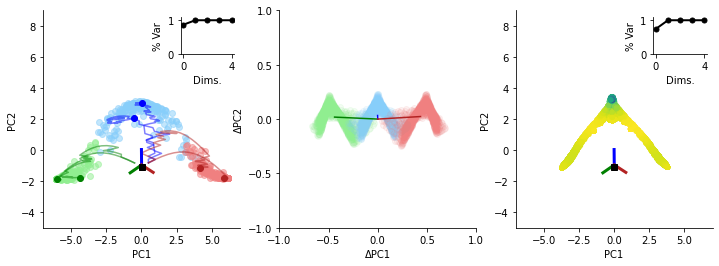

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131);
ax2 = fig.add_subplot(133);
ax3 = fig.add_subplot(132);

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['g', 'b', 'firebrick', 'y', 'orange', 'm', 'cyan', 'brown']
state_colors_light = ['lightgreen', 'lightskyblue', 'lightcoral', 'bisque']

n_to_plot = 5

##### Hidden States #####

for i in range(len(toy_params['sentiments'])):
  for state_idx in range(int(n_hs_trials/3)): # Plots grey final states
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors_light[i], marker='o', alpha=0.5)
  for state_idx in range(6,8): # Only plots 3 for each color
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = state_colors[i], marker=None, alpha=0.5)
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors[i], marker='o', alpha=1.0)
  

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax1.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))
  ax2.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 1
iax1 = plt.axes([0,0,1,1])
iax1.set_axes_locator(InsetPosition(ax1, [0.7,0.8,0.27,0.17]))
iax1.plot(range(n_to_plot), total_exvar_hs[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax1.set_ylim(0,1.1)
iax1.set_xlabel('Dims.')
iax1.set_ylabel('% Var')
iax1.set_xticks([0,n_to_plot-1])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
ax2.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.7,0.8,0.27,0.17]))
iax2.plot(range(n_to_plot), total_exvar_fp[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax2.set_ylim(0,1.1)
iax2.set_xlabel('Dims.')
iax2.set_ylabel('% Var')
iax2.set_xticks([0,n_to_plot-1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

##### Flows #####

# ax3.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='lightgrey', alpha=1.0)

# Inset 3
# iax3 = plt.axes([0,0,1,1.0001])
# iax3.set_axes_locator(InsetPosition(ax3, [0.7,0.7,0.27,0.27]))
def_colors = ['g', 'b', 'firebrick', 'b', 'orange', 'm', 'cyan', 'brown']

for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 0:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=def_colors[word_idx])
  ax3.scatter(defs1, defs2, color=state_colors_light[word_idx], alpha=0.1)
  ax3.set_xlim(-1,1)
  ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_yticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_ylim(-1,1)
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

main_axs = [ax1, ax2]
x_lims = (-7, 7)
y_lims = (-5, 9)
for axis in main_axs:
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

all_axs = [ax1, ax2, ax3, iax1, iax2]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)


####5-Class Ordered Plots

##### Weak L2

In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_5class_uniformscore_noRO_l2is1e-3_2.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

##### Strong L2

In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_5class_uniformscore_noRO_l2is1e-2.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


In [ ]:
cell = syn_an.build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_hs_trials = 600
pc_dims = 5

syn_data_test = syn.generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

readout = readout_params.T

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', syn_an.participation_ratio_vector(pca_full.explained_variance_))
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)

# The initial state.
h0 = cell.get_initial_state(rnn_params)

word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/3*jnp.ones(rnn_specs['input_size'])

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-2, steps=range(10000))

# PCA on fixed points
pca_full_fp = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full_fp.fit_transform(fixed_points)
explained_var = pca_full_fp.explained_variance_ratio_
total_exvar_fp = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_fp.append(np.sum(explained_var[:i+1]))

# Filters out non-unique points for flows
unique_tol = 0.025
do_print = True
points_unique, unique_kidxs = syn_an.keep_unique_fixed_points(pts, unique_tol, do_print)
steps = 1

words = ['bad', 'the', 'good']
points_reduced = points_unique
points_final_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = syn.wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

Using GRU cell
Looking for num per class: [120. 120. 120. 120. 120.]
Sythentic data generated in: 0.08 sec. Autobalanced: True. Uniform score: True
(14700, 128)
Copy this: PCA: [5.2881038e-01 4.6116170e-01 6.5915501e-03 2.9202090e-03 4.0730013e-04] PR: 2.0310231311372515
Category 0 states: 120
Category 1 states: 120
Category 2 states: 120
Category 3 states: 120
Category 4 states: 120
Using word tensor: [0.33333334 0.33333334 0.33333334]
    Kept 11467/14700 unique fixed points with uniqueness tolerance 0.025000.


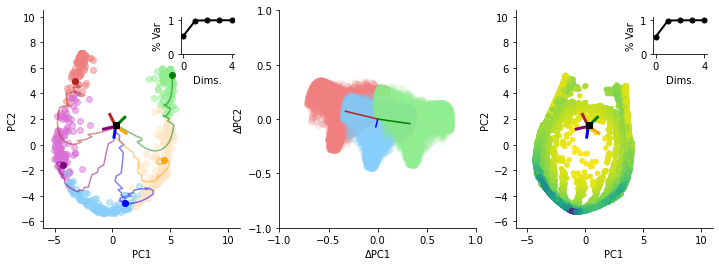

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131);
ax2 = fig.add_subplot(133);
ax3 = fig.add_subplot(132);

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['firebrick', 'purple', 'b', 'orange', 'g']
state_colors_light = ['lightcoral', 'orchid', 'lightskyblue', 'bisque', 'lightgreen']

n_to_plot = 5

##### Hidden States #####

for i in range(len(toy_params['sentiments'])):
  for state_idx in range(int(n_hs_trials/5)): # Plots grey final states
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors_light[i], marker='o', alpha=0.5)
  for state_idx in range(1): # Only plots 3 for each color
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = state_colors[i], marker=None, alpha=0.5)
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors[i], marker='o', alpha=1.0)
  

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax1.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))
  ax2.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 1
iax1 = plt.axes([0,0,1,1])
iax1.set_axes_locator(InsetPosition(ax1, [0.7,0.8,0.27,0.17]))
iax1.plot(range(n_to_plot), total_exvar_hs[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax1.set_ylim(0,1.1)
iax1.set_xlabel('Dims.')
iax1.set_ylabel('% Var')
iax1.set_xticks([0,n_to_plot-1])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
ax2.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.7,0.8,0.27,0.17]))
iax2.plot(range(n_to_plot), total_exvar_fp[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax2.set_ylim(0,1.1)
iax2.set_xlabel('Dims.')
iax2.set_ylabel('% Var')
iax2.set_xticks([0,n_to_plot-1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

##### Flows #####

# ax3.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='lightgrey', alpha=1.0)

# Inset 3
# iax3 = plt.axes([0,0,1,1.0001])
# iax3.set_axes_locator(InsetPosition(ax3, [0.7,0.7,0.27,0.27]))
def_colors = ['firebrick', 'b', 'g']
def_colors_light = ['lightcoral', 'lightskyblue', 'lightgreen']

for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 0:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=def_colors[word_idx])
  ax3.scatter(defs1, defs2, color=def_colors_light[word_idx], alpha=0.1)
  ax3.set_xlim(-1,1)
  ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_yticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_ylim(-1,1)
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

main_axs = [ax1, ax2]
x_lims = (-6, 11)
y_lims = (-6.5, 10.5)
for axis in main_axs:
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

all_axs = [ax1, ax2, ax3, iax1, iax2]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)


In [ ]:
# Filters out non-unique points for flows
unique_tol = 0.5
do_print = True
points_unique, unique_kidxs = syn_an.keep_unique_fixed_points(pts, unique_tol, do_print)
steps = 1

words = ['bad', 'the', 'good']
points_reduced = points_unique
points_final_def_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = syn.wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_def_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_def_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

    Kept 167/14700 unique fixed points with uniqueness tolerance 0.500000.


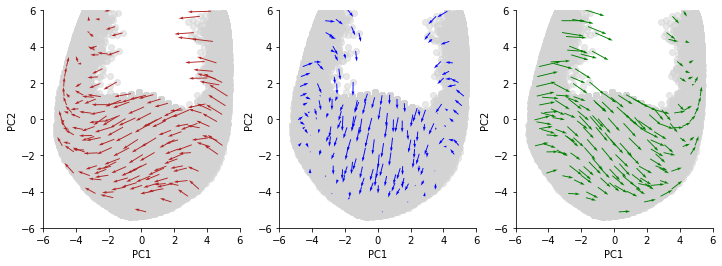

In [ ]:
##### Flows #####
pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
all_axs = [ax1, ax2, ax3]

for axis in all_axs:
  for i in range(len(toy_params['sentiments'])):
    for state_idx in range(int(n_hs_trials/5)): # Plots grey final states
      pca_state = pca.transform(states[i][state_idx]).T
      axis.scatter(pca_state[pc1, :], pca_state[pc2, :], c = 'lightgrey', marker='o', alpha=0.5)
for word_idx in range(len(words)):
  defs1 = points_final_def_pca[word_idx,:,pc1]-points_init_def_pca[:,pc1]
  defs2 = points_final_def_pca[word_idx,:,pc2]-points_init_def_pca[:,pc2]
  all_axs[word_idx].quiver(points_init_def_pca[:,pc1], points_init_def_pca[:,pc2], defs1, defs2, units='xy', scale=1/2, color=def_colors[word_idx])

x_lims = (-6, 6)
y_lims = (-6, 6)

for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

In [ ]:
take_every = 5
n_top = 8
n_fp = len(fixed_points)
print('Evaluating {} fixed points.'.format(n_fp))
max_evals_mag = np.zeros((int(n_fp/take_every), n_top))
max_evals = np.zeros((int(n_fp/take_every), n_top))
pc_dim_val = np.zeros(int(n_fp/take_every))

# input_word = jnp.zeros(rnn_specs['input_size'])
input_word = 1/4*jnp.ones(rnn_specs['input_size'])

for i in tqdm(range(0, int(n_fp/take_every))):
  fp = fixed_points[i*take_every]
  jac = jax.device_get(cell.rec_jac(rnn_params, input_word, fp))
  _, E, _ = renn.eigsorted(jac)
  Emags = np.absolute(E)
  rE = np.real(E)
  rE.sort()
  Emags.sort()
  max_evals_mag[i] = Emags[-n_top:]
  max_evals[i] = rE[-n_top:]

Evaluating 14700 fixed points.


Text(0, 0.5, '|Time Constant|')

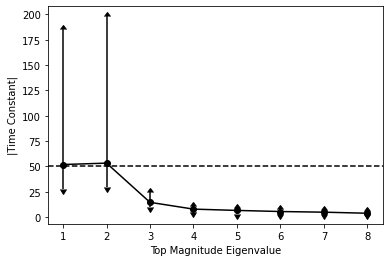

In [ ]:
tc_means = np.zeros((n_top,)) 
tc_medians = np.zeros((n_top,))
tc_75perc = np.zeros((n_top,)) 
tc_25perc = np.zeros((n_top,)) 
tc_err_bars = np.zeros((2, n_top)) 
for i in range(n_top):
  tcs = np.abs(1/np.log(max_evals_mag[:,n_top-1-i]))
  tc_means[i] = np.mean(tcs)
  tc_medians[i] = np.median(tcs)
  tc_75perc[i] = np.percentile(tcs, 90) 
  tc_25perc[i] = np.percentile(tcs, 10)
  tc_err_bars[0,i] = tc_medians[i]-tc_25perc[i]
  tc_err_bars[1,i] = tc_75perc[i] - tc_medians[i] 


plt.figure()
plt.errorbar(np.asarray(range(n_top))+1, tc_medians, yerr=tc_err_bars, xerr=None, uplims=True, lolims=True, marker='o', color='k')
plt.axhline(50, color='k', linestyle='dashed')
plt.xlabel('Top Magnitude Eigenvalue')
plt.ylabel('|Time Constant|')

##### More Words

In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_5class_uniformscore_fullwordset_noRO_l2is5e-3_2.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


In [ ]:
cell = syn_an.build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_hs_trials = 600
pc_dims = 5

syn_data_test = syn.generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

readout = readout_params.T

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', syn_an.participation_ratio_vector(pca_full.explained_variance_))
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)

# The initial state.
h0 = cell.get_initial_state(rnn_params)

word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/5*jnp.ones(rnn_specs['input_size'])

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-2, steps=range(10000))

# PCA on fixed points
pca_full_fp = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full_fp.fit_transform(fixed_points)
explained_var = pca_full_fp.explained_variance_ratio_
total_exvar_fp = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_fp.append(np.sum(explained_var[:i+1]))

# Filters out non-unique points for flows
unique_tol = 0.025
do_print = True
points_unique, unique_kidxs = syn_an.keep_unique_fixed_points(pts, unique_tol, do_print)
steps = 1

words = ['awful', 'bad', 'the', 'good', 'awesome']
points_reduced = points_unique
points_final_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = syn.wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

Using GRU cell
Looking for num per class: [120. 120. 120. 120. 120.]
Sythentic data generated in: 0.49 sec. Autobalanced: True. Uniform score: True
(8700, 128)
Copy this: PCA: [0.50158596 0.47977474 0.01309349 0.00249868 0.00223967] PR: 2.074881183361508
Category 0 states: 120
Category 1 states: 120
Category 2 states: 120
Category 3 states: 120
Category 4 states: 120
Using word tensor: [0.2 0.2 0.2 0.2 0.2]
    Kept 7012/8700 unique fixed points with uniqueness tolerance 0.025000.


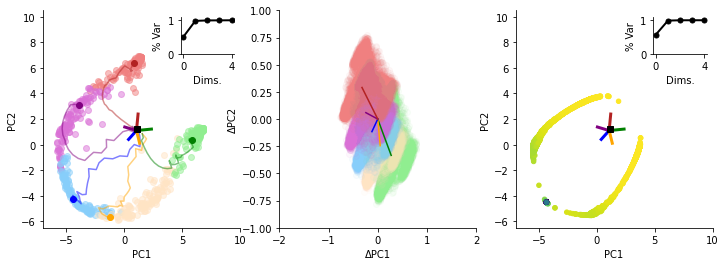

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131);
ax2 = fig.add_subplot(133);
ax3 = fig.add_subplot(132);

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['firebrick', 'purple', 'b', 'orange', 'g']
state_colors_light = ['lightcoral', 'orchid', 'lightskyblue', 'bisque', 'lightgreen']

n_to_plot = 5

##### Hidden States #####

for i in range(len(toy_params['sentiments'])):
  for state_idx in range(int(n_hs_trials/5)): # Plots grey final states
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.scatter(pca_state[pc1, toy_params['phrase_length']-2], pca_state[pc2, toy_params['phrase_length']-2], c = state_colors_light[i], marker='o', alpha=0.5)
  for state_idx in range(1): # Only plots 3 for each color
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = state_colors[i], marker=None, alpha=0.5)
    ax1.scatter(pca_state[pc1, toy_params['phrase_length']-2], pca_state[pc2, toy_params['phrase_length']-2], c = state_colors[i], marker='o', alpha=1.0)
  

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax1.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))
  ax2.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 1
iax1 = plt.axes([0,0,1,1])
iax1.set_axes_locator(InsetPosition(ax1, [0.7,0.8,0.27,0.17]))
iax1.plot(range(n_to_plot), total_exvar_hs[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax1.set_ylim(0,1.1)
iax1.set_xlabel('Dims.')
iax1.set_ylabel('% Var')
iax1.set_xticks([0,n_to_plot-1])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
ax2.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.7,0.8,0.27,0.17]))
iax2.plot(range(n_to_plot), total_exvar_fp[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax2.set_ylim(0,1.1)
iax2.set_xlabel('Dims.')
iax2.set_ylabel('% Var')
iax2.set_xticks([0,n_to_plot-1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

##### Flows #####

# ax3.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='lightgrey', alpha=1.0)

# Inset 3
# iax3 = plt.axes([0,0,1,1.0001])
# iax3.set_axes_locator(InsetPosition(ax3, [0.7,0.7,0.27,0.27]))
def_colors = ['firebrick', 'purple', 'b', 'orange', 'g']
def_colors_light = ['lightcoral', 'orchid', 'lightskyblue', 'bisque', 'lightgreen']

for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 0:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=def_colors[4-word_idx])
  ax3.scatter(defs1, defs2, color=def_colors_light[4-word_idx], alpha=0.05)
  ax3.set_xlim(-2.0,2.0)
  # ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
  # ax3.set_yticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_ylim(-1.0,1.0)
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

main_axs = [ax1, ax2]
x_lims = (-7, 10)
y_lims = (-6.5, 10.5)
for axis in main_axs:
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

all_axs = [ax1, ax2, ax3, iax1, iax2]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)


In [ ]:
syn_data_test_shuf = np.copy(syn_data_test_raw['inputs'])
for phrase_idx in range(syn_data_test_raw['inputs'].shape[0]):
  print('Total words:', np.sum(syn_data_test_raw['inputs'][phrase_idx], axis=0))
  np.random.shuffle(syn_data_test_shuf[phrase_idx])
  print('Shuf Total words:', np.sum(syn_data_test_shuf[phrase_idx], axis=0))

Total words: [ 1.  0.  2. 16. 11.]
Shuf Total words: [ 1.  0.  2. 16. 11.]
Total words: [2. 7. 8. 8. 5.]
Shuf Total words: [2. 7. 8. 8. 5.]
Total words: [11.  2.  6.  3.  8.]
Shuf Total words: [11.  2.  6.  3.  8.]
Total words: [ 1. 25.  2.  2.  0.]
Shuf Total words: [ 1. 25.  2.  2.  0.]
Total words: [ 9. 16.  0.  4.  1.]
Shuf Total words: [ 9. 16.  0.  4.  1.]
Total words: [14.  0.  6.  2.  8.]
Shuf Total words: [14.  0.  6.  2.  8.]
Total words: [ 0.  0.  0. 30.  0.]
Shuf Total words: [ 0.  0.  0. 30.  0.]
Total words: [ 2.  6.  5. 17.  0.]
Shuf Total words: [ 2.  6.  5. 17.  0.]
Original: [[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]
Shuffle: [[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [ ]:
# Tests data shuffling
n_shuf = 500
syn_data_test_raw = syn.generate_data(n_shuf, toy_params, rnn_specs['output_size'], auto_balance=False, jnp_arrays=False)

syn_data_test = {
  'inputs': jnp.asarray(syn_data_test_raw['inputs']),  # Phrase tensors: dataset_size x phrase_len x in_dim
  'labels': jnp.asarray(syn_data_test_raw['labels']), # Sentiment tensors: dataset_size x phrase_len x out_dim
  'index': jnp.asarray(syn_data_test_raw['index'], dtype=jnp.int32), # Target mask: list of integers up to phrase_len
}
hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)

syn_data_input_shuf = np.copy(syn_data_test_raw['inputs'])
for phrase_idx in range(syn_data_test_raw['inputs'].shape[0]):
  np.random.shuffle(syn_data_input_shuf[phrase_idx])

syn_data_test_shuf = {
  'inputs': jnp.asarray(syn_data_input_shuf),  # Phrase tensors: dataset_size x phrase_len x in_dim
  'labels': jnp.asarray(syn_data_test_raw['labels']), # Sentiment tensors: dataset_size x phrase_len x out_dim
  'index': jnp.asarray(syn_data_test_raw['index'], dtype=jnp.int32), # Target mask: list of integers up to phrase_len
}
hs_shuf = syn_an.rnn_states(cell, syn_data_test_shuf, rnn_params, only_final=False)

pca_hs = pca.transform(np.vstack(hs)).T
pca_hs_shuf = pca.transform(np.vstack(hs_shuf)).T

Sythentic data generated in: 0.36 sec. Autobalanced: False. Uniform score: True


Average diff: 0.1316980196215445
Class diff: 0.936


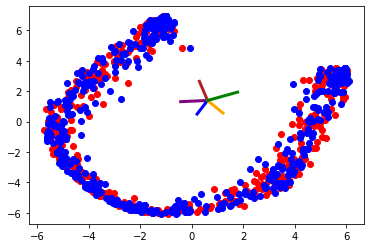

In [ ]:
pc0_coords = []
pc1_coords = []
pc0_shuf_coords = []
pc1_shuf_coords = []
norm_diff = np.zeros((n_shuf))
class_diff = np.zeros((n_shuf))

for i in range(n_shuf):
  pca_hs = pca.transform(hs[i])[28]
  pca_hs_shuf = pca.transform(hs_shuf[i])[28]
  pc0_coords.append(pca_hs[0])
  pc1_coords.append(pca_hs[1])
  pc0_shuf_coords.append(pca_hs_shuf[0])
  pc1_shuf_coords.append(pca_hs_shuf[1])

  norm_diff[i] = np.linalg.norm(hs[i][28] - hs_shuf[i][28])/np.linalg.norm(hs[i][28])
  
  class_diff[i] = np.argmax(np.dot(readout, hs[i][28])) == np.argmax(np.dot(readout, hs_shuf[i][28])) 


print('Average diff:', np.mean(norm_diff))
print('Class diff:', np.mean(class_diff))

plt.figure()
plt.scatter(pc0_coords, pc1_coords, c='r')
plt.scatter(pc0_shuf_coords, pc1_shuf_coords, c='b')

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))

In [ ]:
# Filters out non-unique points for flows
unique_tol = 0.25
do_print = True
points_unique, unique_kidxs = syn_an.keep_unique_fixed_points(fixed_points, unique_tol, do_print)
steps = 1

words = ['awful', 'bad', 'the', 'good', 'awesome']
points_reduced = points_unique
points_final_def_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = syn.wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_def_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_def_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

    Kept 3821/14700 unique fixed points with uniqueness tolerance 0.250000.


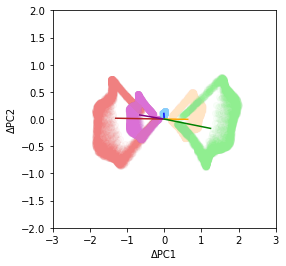

In [ ]:

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(4, 4))
ax3 = fig.add_subplot(111);

def_colors = ['firebrick', 'purple', 'b', 'orange', 'g']
def_colors_light = ['lightcoral', 'orchid', 'lightskyblue', 'bisque', 'lightgreen']

for word_idx in range(len(words)):
  defs1 = points_final_def_pca[word_idx,:,pc1]-points_init_def_pca[:,pc1]
  defs2 = points_final_def_pca[word_idx,:,pc2]-points_init_def_pca[:,pc2]
  # if word_idx == 0:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=def_colors[word_idx])
  ax3.scatter(defs1, defs2, color=def_colors_light[word_idx], alpha=0.05)
  ax3.set_xlim(-3,3)
  # ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
  # ax3.set_yticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_ylim(-2,2)
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

##### Contrived Match

In [67]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_5class_uniformscore_match5order_l2is1e-4.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


In [68]:
cell = syn_an.build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_hs_trials = 600
pc_dims = 5

syn_data_test = syn.generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

readout = readout_params.T

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', syn_an.participation_ratio_vector(pca_full.explained_variance_))
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

# Group these states by the corresponding label.
states = []
states_pred = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  states_pred.append([h for h in hs if np.argmax(np.matmul(readout, h[toy_params['phrase_length']-2])) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)

# The initial state.
h0 = cell.get_initial_state(rnn_params)

word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/5*jnp.ones(rnn_specs['input_size'])

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=5e-3, steps=range(10000))

# PCA on fixed points
pca_full_fp = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full_fp.fit_transform(fixed_points)
explained_var = pca_full_fp.explained_variance_ratio_
total_exvar_fp = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_fp.append(np.sum(explained_var[:i+1]))

# Filters out non-unique points for flows
unique_tol = 0.025
do_print = True
points_unique, unique_kidxs = syn_an.keep_unique_fixed_points(pts, unique_tol, do_print)
steps = 1

words = ['awful', 'bad', 'the', 'good', 'awesome', 'okay']
points_reduced = points_unique
points_final_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = syn.wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

Using GRU cell
Generating score map for uniform scores...
Looking for num per class: [120. 120. 120. 120. 120.]
Three score (-5.0, 27.5)
Three score (-8.0, 14.0)
Three score (-1.0, 13.5)
Three score (12.0, 12.0)
Three score (3.0, 18.5)
Three score (-2.0, 9.0)
Three score (-6.0, 19.0)
Three score (-3.0, 23.5)
Three score (-16.0, 16.0)
Three score (6.0, 18.0)
Three score (-12.0, 13.0)
Three score (1.0, 8.5)
Three score (-1.0, 12.5)
Three score (-4.0, 23.0)
Three score (7.0, 7.5)
Three score (3.0, 12.5)
Three score (-2.0, 8.0)
Three score (0.0, 13.0)
Three score (-4.0, 22.0)
Three score (7.0, 7.5)
Three score (1.0, 2.5)
Three score (-2.0, 6.0)
Three score (4.0, 16.0)
Three score (5.0, 19.5)
Three score (-9.0, 16.5)
Three score (-1.0, 17.5)
Three score (1.0, 8.5)
Three score (-1.0, 29.5)
Three score (-2.0, 26.0)
Three score (-6.0, 6.0)
Three score (-11.0, 12.5)
Three score (-11.0, 14.5)
Three score (11.0, 18.5)
Three score (-4.0, 20.0)
Three score (2.0, 28.0)
Three score (-3.0, 11.5)
Three

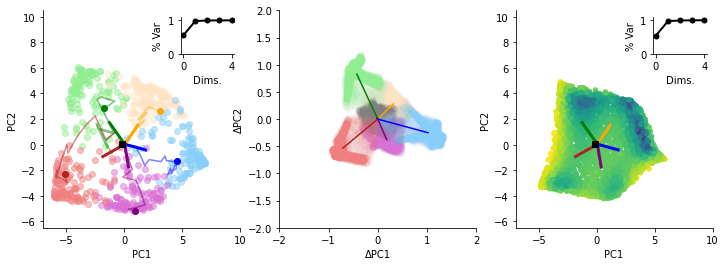

In [66]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131);
ax2 = fig.add_subplot(133);
ax3 = fig.add_subplot(132);

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['firebrick', 'purple', 'b', 'orange', 'g']
state_colors_light = ['lightcoral', 'orchid', 'lightskyblue', 'bisque', 'lightgreen']

n_to_plot = 5

##### Hidden States #####

state_plot = states

for i in range(len(toy_params['sentiments'])):
  for state_idx in range(int(len(state_plot[i]))): # Plots grey final states
    pca_state = pca.transform(state_plot[i][state_idx]).T
    ax1.scatter(pca_state[pc1, toy_params['phrase_length']-2], pca_state[pc2, toy_params['phrase_length']-2], c = state_colors_light[4-i], marker='o', alpha=0.5)
  for state_idx in range(1): # Only plots 3 for each color
    pca_state = pca.transform(state_plot[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = state_colors[4-i], marker=None, alpha=0.5)
    ax1.scatter(pca_state[pc1, toy_params['phrase_length']-2], pca_state[pc2, toy_params['phrase_length']-2], c = state_colors[4-i], marker='o', alpha=1.0)
  

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax1.plot(x_ro, y_ro, state_colors[4-i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))
  ax2.plot(x_ro, y_ro, state_colors[4-i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 1
iax1 = plt.axes([0,0,1,1])
iax1.set_axes_locator(InsetPosition(ax1, [0.7,0.8,0.27,0.17]))
iax1.plot(range(n_to_plot), total_exvar_hs[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax1.set_ylim(0,1.1)
iax1.set_xlabel('Dims.')
iax1.set_ylabel('% Var')
iax1.set_xticks([0,n_to_plot-1])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
ax2.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.7,0.8,0.27,0.17]))
iax2.plot(range(n_to_plot), total_exvar_fp[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax2.set_ylim(0,1.1)
iax2.set_xlabel('Dims.')
iax2.set_ylabel('% Var')
iax2.set_xticks([0,n_to_plot-1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

##### Flows #####

# ax3.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='lightgrey', alpha=1.0)

# Inset 3
# iax3 = plt.axes([0,0,1,1.0001])
# iax3.set_axes_locator(InsetPosition(ax3, [0.7,0.7,0.27,0.27]))
def_colors = ['firebrick', 'purple', 'k', 'orange', 'g', 'b']
def_colors_light = ['lightcoral', 'orchid', 'grey', 'bisque', 'lightgreen', 'lightskyblue']

for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 0:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=def_colors[4-word_idx])
  ax3.scatter(defs1, defs2, color=def_colors_light[4-word_idx], alpha=0.025)
  ax3.set_xlim(-2.0,2.0)
  # ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
  # ax3.set_yticks([-1, -0.5, 0, 0.5, 1])
  ax3.set_ylim(-2.0,2.0)
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

main_axs = [ax1, ax2]
x_lims = (-7, 10)
y_lims = (-6.5, 10.5)
for axis in main_axs:
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

all_axs = [ax1, ax2, ax3, iax1, iax2]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)


#### Non-Exclusive Plots

##### 2 Outer

In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_2classrgb_2outer_noRO_l2is5e-4.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


In [ ]:
cell = syn_an.build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_hs_trials = 600
pc_dims = 5

syn_data_test = syn.generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

readout = readout_params.T

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', syn_an.participation_ratio_vector(pca_full.explained_variance_))
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

# Group these states by the corresponding label.
states = []
state_vecs = np.asarray([[0,1], [1,0], [0,0], [1,1]])
for i in range(len(toy_params['sentiments'])**2):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if (lbl[toy_params['phrase_length']-1] == state_vecs[i]).all()])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)

# The initial state.
h0 = cell.get_initial_state(rnn_params)

word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/4*jnp.ones(rnn_specs['input_size'])

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-4, steps=range(10000))

# PCA on fixed points
pca_full_fp = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full_fp.fit_transform(fixed_points)
explained_var = pca_full_fp.explained_variance_ratio_
total_exvar_fp = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_fp.append(np.sum(explained_var[:i+1]))

# Filters out non-unique points for flows
unique_tol = 0.5
do_print = True
points_unique, unique_kidxs = syn_an.keep_unique_fixed_points(pts, unique_tol, do_print)
steps = 1

words = ['kinda0', 'kinda1', 'bad0', 'bad1', 'the']
points_reduced = points_unique
points_final_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = syn.wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

Using GRU cell
Looking for num per class: [150. 150. 150. 150.]
Sythentic data generated in: 0.26 sec. Autobalanced: True. Uniform score: False
(14700, 128)
Copy this: PCA: [0.5105175  0.46124944 0.01032605 0.00820812 0.0025909 ] PR: 2.111624547455116
Category 0 states: 150
Category 1 states: 150
Category 2 states: 150
Category 3 states: 150
Using word tensor: [0.25 0.25 0.25 0.25 0.25]
    Kept 604/14700 unique fixed points with uniqueness tolerance 0.500000.


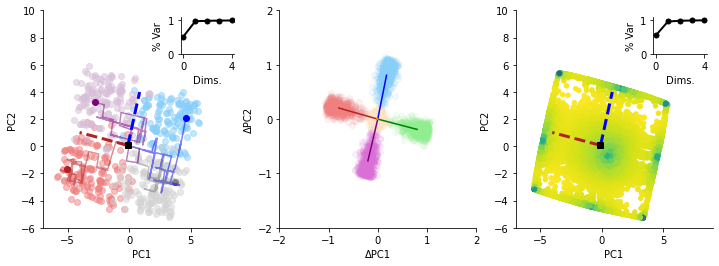

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131);
ax2 = fig.add_subplot(133);
ax3 = fig.add_subplot(132);

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['b', 'firebrick', 'grey', 'purple', 'orange', 'm', 'cyan', 'brown']
state_colors_light = ['lightskyblue', 'lightcoral', 'lightgray', 'thistle', 'bisque']

n_to_plot = 5

##### Hidden States #####
for i in range(len(toy_params['sentiments'])**2):
  for state_idx in range(int(n_hs_trials/4)): # Plots grey final states
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors_light[i], marker='o', alpha=0.5)
  for state_idx in range(2,3): # Only plots 1 for each color
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = state_colors[i], marker=None, alpha=0.5)
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors[i], marker='o', alpha=1.0)

# Plots readout direction
ro_colors = ['firebrick', 'b']
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax1.plot(x_ro, y_ro, ro_colors[i], linewidth = 3, linestyle = 'dashed', label='RO'+str(i))
  ax2.plot(x_ro, y_ro, ro_colors[i], linewidth = 3, linestyle = 'dashed', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 1
iax1 = plt.axes([0,0,1,1])
iax1.set_axes_locator(InsetPosition(ax1, [0.7,0.8,0.27,0.17]))
iax1.plot(range(n_to_plot), total_exvar_hs[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax1.set_ylim(0,1.1)
iax1.set_xlabel('Dims.')
iax1.set_ylabel('% Var')
iax1.set_xticks([0,n_to_plot-1])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
ax2.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.7,0.8,0.27,0.17]))
iax2.plot(range(n_to_plot), total_exvar_fp[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax2.set_ylim(0,1.1)
iax2.set_xlabel('Dims.')
iax2.set_ylabel('% Var')
iax2.set_xticks([0,n_to_plot-1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

##### Flows #####

# ax3.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='lightgrey', alpha=1.0)

# Inset 3
# iax3 = plt.axes([0,0,1,1.0001])
# iax3.set_axes_locator(InsetPosition(ax3, [0.7,0.7,0.27,0.27]))
def_colors = ['firebrick', 'b', 'g', 'purple', 'orange']
def_colors_light = ['lightcoral', 'lightskyblue', 'lightgreen', 'orchid', 'bisque']
for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 1:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.scatter(defs1, defs2, color=def_colors_light[word_idx], alpha=0.1)
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=def_colors[word_idx])
  ax3.set_xlim(-2,2)
  ax3.set_xticks([-2, -1, 0, 1, 2])
  ax3.set_yticks([-2, -1, 0, 1, 2])
  ax3.set_ylim(-2,2)
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

main_axs = [ax1, ax2]
x_lims = (-7, 9)
y_lims = (-6, 10)
for axis in main_axs:
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

all_axs = [ax1, ax2, ax3, iax1, iax2]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)

##### 3 Outer

In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_2classrgb_3outer_noRO_l2is5e-4.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


In [ ]:
cell = syn_an.build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_hs_trials = 600
pc_dims = 5

syn_data_test = syn.generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

readout = readout_params.T

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', syn_an.participation_ratio_vector(pca_full.explained_variance_))
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

# Group these states by the corresponding label.
states = []
state_vecs = np.asarray([[0,0,0], [0,0,1], [0,1,0], [1,0,0], [0,1,1], [1,0,1], [1,1,0], [1,1,1]])
for i in range(2**len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if (lbl[toy_params['phrase_length']-1] == state_vecs[i]).all()])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)

# The initial state.
h0 = cell.get_initial_state(rnn_params)

word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/7*jnp.ones(rnn_specs['input_size'])

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-4, steps=range(10000))

# PCA on fixed points
pca_full_fp = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full_fp.fit_transform(fixed_points)
explained_var = pca_full_fp.explained_variance_ratio_
total_exvar_fp = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_fp.append(np.sum(explained_var[:i+1]))

# Filters out non-unique points for flows
unique_tol = 0.5
do_print = True
points_unique, unique_kidxs = syn_an.keep_unique_fixed_points(pts, unique_tol, do_print)
steps = 1

words = ['kinda0', 'kinda1', 'kinda2', 'bad0', 'bad1', 'bad2', 'the']
points_reduced = points_unique
points_final_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = syn.wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

Using GRU cell
Looking for num per class: [75. 75. 75. 75. 75. 75. 75. 75.]
Sythentic data generated in: 0.29 sec. Autobalanced: True. Uniform score: False
(14700, 128)
Copy this: PCA: [0.33367085 0.32504675 0.31566754 0.00976985 0.00483536] PR: 3.156785255777476
Category 0 states: 75
Category 1 states: 75
Category 2 states: 75
Category 3 states: 75
Category 4 states: 75
Category 5 states: 75
Category 6 states: 75
Category 7 states: 75
Using word tensor: [0.14285715 0.14285715 0.14285715 0.14285715 0.14285715 0.14285715
 0.14285715]
    Kept 4936/14700 unique fixed points with uniqueness tolerance 0.500000.


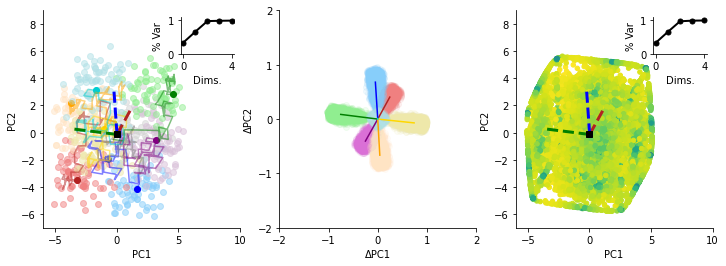

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131);
ax2 = fig.add_subplot(133);
ax3 = fig.add_subplot(132);

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['b', 'firebrick', 'grey', 'purple', 'orange', 'gold', 'green', 'darkturquoise']
state_colors_light = ['lightskyblue', 'lightcoral', 'lightgray', 'thistle', 'bisque', 'palegoldenrod', 'lightgreen', 'powderblue']

n_to_plot = 5

##### Hidden States #####
for i in range(2**len(toy_params['sentiments'])):
  for state_idx in range(int(n_hs_trials/8)): # Plots grey final states
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors_light[i], marker='o', alpha=0.5)
  for state_idx in range(1): # Only plots 1 for each color
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = state_colors[i], marker=None, alpha=0.5)
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors[i], marker='o', alpha=1.0)

# Plots readout direction
ro_colors = ['firebrick', 'b', 'g']
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  ax1.plot(x_ro, y_ro, ro_colors[i], linewidth = 3, linestyle = 'dashed', label='RO'+str(i))
  ax2.plot(x_ro, y_ro, ro_colors[i], linewidth = 3, linestyle = 'dashed', label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 1
iax1 = plt.axes([0,0,1,1])
iax1.set_axes_locator(InsetPosition(ax1, [0.7,0.8,0.27,0.17]))
iax1.plot(range(n_to_plot), total_exvar_hs[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax1.set_ylim(0,1.1)
iax1.set_xlabel('Dims.')
iax1.set_ylabel('% Var')
iax1.set_xticks([0,n_to_plot-1])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
ax2.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.7,0.8,0.27,0.17]))
iax2.plot(range(n_to_plot), total_exvar_fp[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax2.set_ylim(0,1.1)
iax2.set_xlabel('Dims.')
iax2.set_ylabel('% Var')
iax2.set_xticks([0,n_to_plot-1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

##### Flows #####

# ax3.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='lightgrey', alpha=1.0)

# Inset 3
# iax3 = plt.axes([0,0,1,1.0001])
# iax3.set_axes_locator(InsetPosition(ax3, [0.7,0.7,0.27,0.27]))
def_colors = ['firebrick', 'b', 'g', 'purple', 'orange', 'gold', 'darkturquoise']
def_colors_light = ['lightcoral', 'lightskyblue', 'lightgreen', 'orchid', 'bisque', 'palegoldenrod', 'powderblue']
for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 1:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.scatter(defs1, defs2, color=def_colors_light[word_idx], alpha=0.1)
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=def_colors[word_idx])
  ax3.set_xlim(-2,2)
  ax3.set_xticks([-2, -1, 0, 1, 2])
  ax3.set_yticks([-2, -1, 0, 1, 2])
  ax3.set_ylim(-2,2)
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

main_axs = [ax1, ax2]
x_lims = (-6, 10)
y_lims = (-7, 9)
for axis in main_axs:
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

all_axs = [ax1, ax2, ax3, iax1, iax2]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)

#### Ordered Unordered Interpolation Plot

In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_3classrgb_minimal_eps2is01_noRO_l2is5e-4.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


In [ ]:
cell = syn_an.build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_hs_trials = 600
pc_dims = 5

syn_data_test = syn.generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

readout = readout_params.T

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', syn_an.participation_ratio_vector(pca_full.explained_variance_))
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)

# The initial state.
h0 = cell.get_initial_state(rnn_params)

word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/3*jnp.ones(rnn_specs['input_size'])

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-3, steps=range(10000))

# PCA on fixed points
pca_full_fp = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full_fp.fit_transform(fixed_points)
explained_var = pca_full_fp.explained_variance_ratio_
total_exvar_fp = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_fp.append(np.sum(explained_var[:i+1]))

# Filters out non-unique points for flows
unique_tol = 0.1
do_print = True
points_unique, unique_kidxs = syn_an.keep_unique_fixed_points(pts, unique_tol, do_print)
steps = 1

words = ['kinda0', 'kinda1', 'kinda2']
points_reduced = points_unique
points_final_pca = np.zeros((len(words), len(points_reduced), pc_dims))

for word_idx in range(len(words)):
  word_tensor = syn.wordToTensor(words[word_idx], toy_params['words'])[0]
  points_init_pca = pca.transform(np.vstack(points_reduced))
  for pt_idx in range(len(points_reduced)):
    ref_point = points_reduced[pt_idx]
    for step in range(steps):
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
      ref_point = def_state
    points_final_pca[word_idx, pt_idx] = pca.transform(np.atleast_2d(def_state))[0]

Using GRU cell
Looking for num per class: [200. 200. 200.]
Sythentic data generated in: 0.26 sec. Autobalanced: True. Uniform score: False
(14700, 128)
Copy this: PCA: [0.688198   0.25854492 0.02006184 0.00834405 0.00722601] PR: 1.8482849618574222
Category 0 states: 200
Category 1 states: 200
Category 2 states: 200
Using word tensor: [0.33333334 0.33333334 0.33333334]
    Kept 12199/14700 unique fixed points with uniqueness tolerance 0.100000.


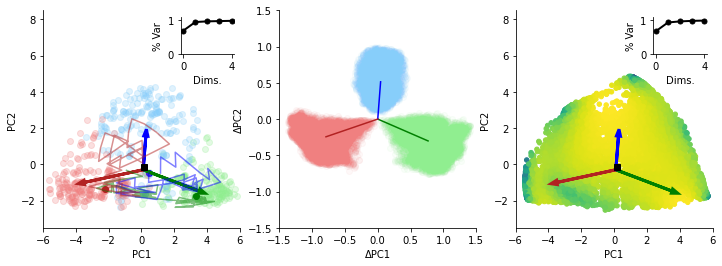

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pc1 = 0
pc2 = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131);
ax2 = fig.add_subplot(133);
ax3 = fig.add_subplot(132);

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['g', 'b', 'firebrick', 'y', 'orange', 'm', 'cyan', 'brown']
state_colors_light = ['lightgreen', 'lightskyblue', 'lightcoral']
n_to_plot = 5

##### Hidden States #####

for i in range(len(toy_params['sentiments'])):
  for state_idx in range(int(n_hs_trials/3)): # Plots grey final states
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors_light[i], marker='o', alpha=0.25)
  for state_idx in range(3,4): # Only plots 1 for each color
    pca_state = pca.transform(states[i][state_idx]).T
    ax1.plot(pca_state[pc1], pca_state[pc2], c = state_colors[i], marker=None, alpha=0.5)
    ax1.scatter(pca_state[pc1, 48], pca_state[pc2, 48], c = state_colors[i], marker='o', alpha=1.0)

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  # ax1.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))
  # ax2.plot(x_ro, y_ro, state_colors[i], linewidth = 3, linestyle = 'solid', label='RO'+str(i))
  ax1.arrow(pca_zero[pc1][0], pca_zero[pc2][0], (pca_ro[i][pc1]-pca_zero[pc1])[0], (pca_ro[i][pc2]-pca_zero[pc2])[0]
            , color=state_colors[i], linewidth = 3, head_width = 0.25)
  ax2.arrow(pca_zero[pc1][0], pca_zero[pc2][0], (pca_ro[i][pc1]-pca_zero[pc1])[0], (pca_ro[i][pc2]-pca_zero[pc2])[0]
            , color=state_colors[i], linewidth = 3, head_width = 0.25)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
ax2.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Inset 1
iax1 = plt.axes([0,0,1,1])
iax1.set_axes_locator(InsetPosition(ax1, [0.7,0.8,0.27,0.17]))
iax1.plot(range(n_to_plot), total_exvar_hs[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax1.set_ylim(0,1.1)
iax1.set_xlabel('Dims.')
iax1.set_ylabel('% Var')
iax1.set_xticks([0,n_to_plot-1])

##### Fixed Points #####

pca_fps = pca.transform(np.vstack(fixed_points)).T
ax2.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Inset 2
iax2 = plt.axes([0,0,1.01,1])
iax2.set_axes_locator(InsetPosition(ax2, [0.7,0.8,0.27,0.17]))
iax2.plot(range(n_to_plot), total_exvar_fp[:n_to_plot], color='black', marker='o', markersize=5, linewidth=2)
iax2.set_ylim(0,1.1)
iax2.set_xlabel('Dims.')
iax2.set_ylabel('% Var')
iax2.set_xticks([0,n_to_plot-1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

##### Flows #####

# ax3.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='lightgrey', alpha=1.0)

# Inset 3
# iax3 = plt.axes([0,0,1,1.0001])
# iax3.set_axes_locator(InsetPosition(ax3, [0.7,0.7,0.27,0.27]))

for word_idx in range(len(words)):
  defs1 = points_final_pca[word_idx,:,pc1]-points_init_pca[:,pc1]
  defs2 = points_final_pca[word_idx,:,pc2]-points_init_pca[:,pc2]
  # if word_idx == 1:
  #   ax3.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], defs1, defs2, units='xy', scale=1, color=state_colors[word_idx])
  
  # avg_defs = [np.mean(defs1), np.mean(defs2)]
  ax3.plot([0, np.mean(defs1)], [0, np.mean(defs2)], color=state_colors[word_idx])
  ax3.scatter(defs1, defs2, color=state_colors_light[word_idx], alpha=0.05)
  ax3.set_xlim(-1.5,1.5)
  ax3.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
  ax3.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
  ax3.set_xlabel('ΔPC1')
  ax3.set_ylabel('ΔPC2')

main_axs = [ax1, ax2]
x_lims = (-6, 6)
y_lims = (-3.5, 8.5)
for axis in main_axs:
  axis.set_xlabel('PC'+str(pc1+1))
  axis.set_ylabel('PC'+str(pc2+1))
  axis.set_xlim(x_lims[0], x_lims[1])
  axis.set_ylim(y_lims[0], y_lims[1])

all_axs = [ax1, ax2, ax3, iax1, iax2]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)


### Dimensionality Plots

In [ ]:
# Vinay used slightly different modules to generate the data, so need to load them in in order to load in data he generated

sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/synthetic')
from src import synthetic_data as syn
from src import training as syn_train

In [ ]:
import os.path
from os import path

base_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/kyle_rnn_data/'

class_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]
l2_values = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
trials = 10

missing_vals = []

for class_idx in range(len(class_sizes)):
  for l2_idx in range(len(l2_values)):
    for trial in range(trials):
      my_path = base_path + 'gru_{}class_uniformscore_noRO_l2is{}_{}_test.pickle'.format(class_sizes[class_idx], l2_values[l2_idx], trial)
      if not path.exists(my_path):
        missing_vals.append([class_sizes[class_idx], l2_values[l2_idx], trial])

print('Missing vals:', len(missing_vals))
print(missing_vals)

Missing vals: 0
[]


In [ ]:
my_path = base_path + 'gru_{}class_uniformscore_noRO_l2is{}_{}_test.pickle'.format(10, 0.0001, 0)

with open(my_path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

FileNotFoundError: ignored

#### Global PR, Dimension and Accuracy

In [ ]:
base_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/kyle_rnn_data/'

class_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]
l2_values = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
trials = 10

n_hs_trials = 600
pc_dims = 5

prs = np.zeros((len(class_sizes), len(l2_values), trials))
test_accs = np.zeros((len(class_sizes), len(l2_values), trials)) 

for class_idx in range(len(class_sizes)):
  for l2_idx in range(len(l2_values)):
    for trial in range(trials):

      path = base_path + 'gru_{}class_uniformscore_noRO_l2is{}_{}_test.pickle'.format(class_sizes[class_idx], l2_values[l2_idx], trial)

      with open(path, 'rb') as load_file:
          params_loaded = pickle.load(load_file)
          toy_params = pickle.load(load_file)
          rnn_specs = pickle.load(load_file)
          train_params = pickle.load(load_file)

      rnn_params, readout_params = params_loaded
      train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)

      # print('Classes: {}, L2: {}, Trial: {}'.format(toy_params['n_unordered'], train_params['l2reg'], trial))


      # Get RNN hidden states in response to a test batch.
      cell = syn_an.build_cell(rnn_specs)

      syn_data_test = syn.generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

      # Rebuilds RNN to get test accuracy
      init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = syn_train.build_rnn(rnn_specs, train_params)
      test_accs[class_idx, l2_idx, trial] = syn_train.test_accuracy(params_loaded, syn_data_test, accuracy_fun)

      hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
      pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

      readout = readout_params.T

      # Finds percentage of variance explained by top pc_dims of PCA
      pca_full = PCA(n_components=rnn_specs['hidden_size'])
      _ = pca_full.fit_transform(pts)
      explained_var = pca_full.explained_variance_ratio_
      prs[class_idx, l2_idx, trial] = syn_an.participation_ratio_vector(pca_full.explained_variance_ratio_)
      total_exvar_hs = []
      for i in range(rnn_specs['hidden_size']-1):
        total_exvar_hs.append(np.sum(explained_var[:i+1]))

Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data generated in: 0.41 sec. Autobalanced: True. Uniform score: True
Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data generated in: 0.45 sec. Autobalanced: True. Uniform score: True
Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data generated in: 0.40 sec. Autobalanced: True. Uniform score: True
Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data generated in: 0.42 sec. Autobalanced: True. Uniform score: True
Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data generated in: 0.45 sec. Autobalanced: True. Uniform score: True
Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data generated in: 0.43 sec. Autobalanced: True. Uniform score: True
Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data generated in: 0.44 sec. Autobalanced: True. Uniform score: True
Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data 

In [ ]:
base_path_save = '/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/data/l2_vs_N_trials0to9.pickle'
save_data = {
    'prs': prs,
    'test_accs': test_accs,
}
with open(base_path_save, 'wb') as save_file:
  pickle.dump(save_data, save_file, protocol=pickle.HIGHEST_PROTOCOL)
print('Data Saved')

Data Saved


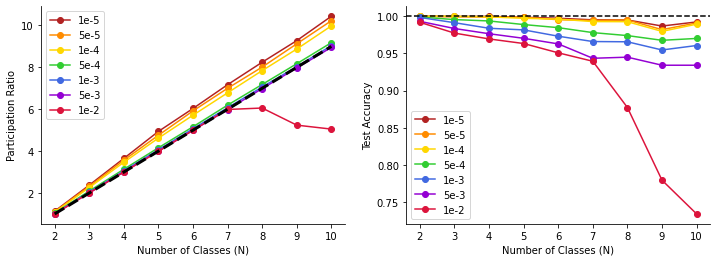

In [ ]:
with open('/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/data/l2_vs_N_trials0to9.pickle', 'rb') as load_file:
  load_data_l2 = pickle.load(load_file)

fig = plt.figure(figsize=(12, 4))
ax6 = fig.add_subplot(121);
ax7 = fig.add_subplot(122);

l2_vals_str = ['1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2']
colors = ['firebrick', 'darkorange', 'gold', 'limegreen', 'royalblue', 'darkviolet', 'crimson']

prs_avg = np.mean(load_data_l2['prs'], axis=2)
test_accs_avg = np.mean(load_data_l2['test_accs'], axis=2)

for l2_idx in range(len(l2_values)):
  ax6.plot(class_sizes, prs_avg[:, l2_idx], marker='o', c=colors[l2_idx])
ax6.plot(class_sizes, [i-1 for i in class_sizes], c='k', linestyle='dashed', linewidth=3)
ax6.set_xlabel('Number of Classes (N)')
ax6.set_ylabel('Participation Ratio')
ax6.legend(l2_vals_str)

for l2_idx in range(len(l2_values)):
  ax7.plot(class_sizes, test_accs_avg[:, l2_idx], marker='o', c=colors[l2_idx])
ax7.set_xlabel('Number of Classes (N)')
ax7.set_ylabel('Test Accuracy')
ax7.axhline(1.0, c='k', linestyle='dashed')
ax7.legend(l2_vals_str)

all_axs = [ax6, ax7]
for axis in all_axs:
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)

In [ ]:
path = base_path + 'gru_{}class_uniformscore_noRO_l2is{}_{}_test.pickle'.format(5, l2_values[6], 0)

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)

# print('Classes: {}, L2: {}, Trial: {}'.format(toy_params['n_unordered'], train_params['l2reg'], trial))


# Get RNN hidden states in response to a test batch.
cell = syn_an.build_cell(rnn_specs)

syn_data_test = syn.generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

# Rebuilds RNN to get test accuracy
init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = syn_train.build_rnn(rnn_specs, train_params)
test_accs[class_idx, l2_idx, trial] = syn_train.test_accuracy(params_loaded, syn_data_test, accuracy_fun)

hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

readout = readout_params.T

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
pts_pca = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
prs[class_idx, l2_idx, trial] = syn_an.participation_ratio_vector(pca_full.explained_variance_ratio_)
total_exvar_hs = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar_hs.append(np.sum(explained_var[:i+1]))

print(explained_var)

Using GRU cell
Looking for num per class: [120. 120. 120. 120. 120.]
Sythentic data generated in: 0.76 sec. Autobalanced: True. Uniform score: True


#### All Dimesionality Measures

In [ ]:
from scipy.spatial.distance import pdist, squareform

base_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/kyle_rnn_data/'

class_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]
l2_value = 5e-4
trials = 5

states = 'Hidden' # Supports 'Hidden' and 'Fixed'
unique_tol = 0.025
do_print = True

n_hs_trials = 600
pc_dims = 5

prs = np.zeros((len(class_sizes), trials))
test_accs = np.zeros((len(class_sizes), trials)) 

local_prs = np.zeros((len(class_sizes), trials))
ve_threshold_var = np.zeros((len(class_sizes), trials))
ve_threshold_90 = np.zeros((len(class_sizes), trials))
ve_threshold_95 = np.zeros((len(class_sizes), trials))

k_vals = [10, 25, 100]
m_k_vals = np.zeros((len(class_sizes), len(k_vals), trials))
corr_dim_vals = np.zeros((len(class_sizes), trials))

for class_idx in range(len(class_sizes)):
  for trial in range(trials):

    path = base_path + 'gru_{}class_uniformscore_noRO_l2is{}_{}_test.pickle'.format(class_sizes[class_idx], l2_value, trial+5)

    with open(path, 'rb') as load_file:
        params_loaded = pickle.load(load_file)
        toy_params = pickle.load(load_file)
        rnn_specs = pickle.load(load_file)
        train_params = pickle.load(load_file)

    rnn_params, readout_params = params_loaded
    train_params, toy_params, rnn_specs = syn_train.default_params(train_params, toy_params, rnn_specs)

    # print('Classes: {}, L2: {}, Trial: {}'.format(toy_params['n_unordered'], train_params['l2reg'], trial))


    # Get RNN hidden states in response to a test batch.
    cell = syn_an.build_cell(rnn_specs)

    syn_data_test = syn.generate_data(n_hs_trials, toy_params, rnn_specs['output_size'], auto_balance=True)

    hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
    pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

    if states == 'Hidden':
      pts_reduced, unique_kidxs = syn_an.keep_unique_fixed_points(pts, unique_tol, do_print)
    elif states == 'Fixed':
      # Average distance traveled
      avg_step_sizes = np.zeros((len(hs),))
      h0 = cell.get_initial_state(rnn_params)
      # print('h0 shape', h0[np.newaxis, :].shape)
      # print('hs shape', hs[0].shape)
      for hs_idx in range(len(hs)):
        hs_h0 = np.concatenate([hs[hs_idx], h0[np.newaxis, :]], axis=0)
        total_dist = 0
        for time_idx in range(hs_h0.shape[0] - 1):
          total_dist += np.sqrt(np.sum((hs_h0[time_idx+1] - hs_h0[time_idx])**2))
        if hs[hs_idx].shape[0] != 0:
          avg_step_sizes[hs_idx] = total_dist/hs[hs_idx].shape[0]
        else:
          print('hs[hs_idx].shape[0] is zero!')

      print('Mean distance:', np.mean(avg_step_sizes))

      xstar = jnp.zeros((pts.shape[0], rnn_specs['input_size']))
      fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
      fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01), 
                                                                  tolerance=.05 * 1/2*(np.mean(avg_step_sizes))**2, steps=range(10000))
      pts_reduced, unique_kidxs = syn_an.keep_unique_fixed_points(fixed_points, unique_tol, do_print)

    # PCA measures
    pca_full = PCA(n_components=rnn_specs['hidden_size'])
    _ = pca_full.fit_transform(pts_reduced)
    prs[class_idx, trial] = syn_an.participation_ratio_vector(pca_full.explained_variance_)
    explained_var = pca_full.explained_variance_ratio_
    num_fp_dims = 1
    while np.sum(explained_var[:num_fp_dims]) < class_sizes[class_idx]/(class_sizes[class_idx]+1):
      num_fp_dims += 1
    ve_threshold_var[class_idx, trial] = num_fp_dims
    num_fp_dims = 1
    while np.sum(explained_var[:num_fp_dims]) < 0.9:
      num_fp_dims += 1
    ve_threshold_90[class_idx, trial] = num_fp_dims
    num_fp_dims = 1
    while np.sum(explained_var[:num_fp_dims]) < 0.95:
      num_fp_dims += 1
    ve_threshold_95[class_idx, trial] = num_fp_dims

    # NN based measures
    distances = pdist(pts_reduced, metric="euclidean") # n_fp * (n_fps-1) / 2
    dist_sq = squareform(distances) # n_fp x n_fp 
    distances.sort()

    for k_val_idx in range(len(k_vals)):
      m_k_vals[class_idx, k_val_idx, trial] = syn_an.find_m_k(k_vals[k_val_idx], dist_sq)

    # r_range = (np.log10(1.1*np.min(distances)), np.log10(0.9*np.max(distances))
    r_range = (np.log10(np.percentile(distances, 2.5)), np.log10(np.percentile(distances, 97.5)))
    slope, _, _, _, _ = syn_an.find_correlation_dimension(r_range, dist_sq, show_plot=False)
    corr_dim_vals[class_idx, trial] = slope

    local_prs[class_idx, trial] = syn_an.local_pca_analysis(pts_reduced, dist_sq, n_pts=20, k=50*class_sizes[class_idx])

Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data generated in: 0.41 sec. Autobalanced: True. Uniform score: True
    Kept 9753/14700 unique fixed points with uniqueness tolerance 0.025000.
Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data generated in: 0.47 sec. Autobalanced: True. Uniform score: True
    Kept 9759/14700 unique fixed points with uniqueness tolerance 0.025000.
Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data generated in: 0.44 sec. Autobalanced: True. Uniform score: True
    Kept 9337/14700 unique fixed points with uniqueness tolerance 0.025000.
Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data generated in: 0.45 sec. Autobalanced: True. Uniform score: True
    Kept 10297/14700 unique fixed points with uniqueness tolerance 0.025000.
Using GRU cell
Looking for num per class: [300. 300.]
Sythentic data generated in: 0.46 sec. Autobalanced: True. Uniform score: True
    Kept 10293/14700 unique fi

In [ ]:
base_path_save = '/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/data/hs_dims_trials5to9_5e-4_change.pickle'
save_data = {
    'prs': prs,
    'local_prs': local_prs,
    've_threshold_var': ve_threshold_var,
    've_threshold_90': ve_threshold_90,
    've_threshold_95': ve_threshold_95,
    'm_k_vals': m_k_vals,
    'corr_dim_vals': corr_dim_vals
}

with open(base_path_save, 'wb') as save_file:
  pickle.dump(save_data, save_file, protocol=pickle.HIGHEST_PROTOCOL)
print('Data Saved')

NameError: ignored

In [ ]:
# Loads data
with open('/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/data/hs_dims_trials0to4_5e-4.pickle', 'rb') as load_file:
  load_data_hs1 = pickle.load(load_file)
with open('/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/data/hs_dims_trials5to9_5e-4.pickle', 'rb') as load_file:
  load_data_hs2 = pickle.load(load_file)

prhs_avg = np.mean(np.concatenate((load_data_hs1['prs'], load_data_hs2['prs']), axis=1), axis=1)
local_prhs_avg = np.mean(np.concatenate((load_data_hs1['local_prs'], load_data_hs2['local_prs']), axis=1), axis=1)
ve_varhs_avg = np.mean(np.concatenate((load_data_hs1['ve_threshold_var'], load_data_hs2['ve_threshold_var']), axis=1), axis=1)
ve_90hs_avg = np.mean(np.concatenate((load_data_hs1['ve_threshold_90'], load_data_hs2['ve_threshold_90']), axis=1), axis=1)
ve_95hs_avg = np.mean(np.concatenate((load_data_hs1['ve_threshold_95'], load_data_hs2['ve_threshold_95']), axis=1), axis=1)
mkhs_avg = np.mean(np.concatenate((load_data_hs1['m_k_vals'], load_data_hs2['m_k_vals']), axis=2), axis=2)
cdhs_avg = np.mean(np.concatenate((load_data_hs1['corr_dim_vals'], load_data_hs2['corr_dim_vals']), axis=1), axis=1)

# Loads data
with open('/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/data/fp_dims_trials0to4_5e-4.pickle', 'rb') as load_file:
  load_data_fp1 = pickle.load(load_file)
with open('/content/drive/My Drive/ml_research/fixedpoints_nlp/figs/data/fp_dims_trials5to9_5e-4.pickle', 'rb') as load_file:
  load_data_fp2 = pickle.load(load_file)

prfp_avg = np.mean(np.concatenate((load_data_fp1['prs'], load_data_fp2['prs']), axis=1), axis=1)
local_prfp_avg = np.mean(np.concatenate((load_data_fp1['local_prs'], load_data_fp2['local_prs']), axis=1), axis=1)
ve_varfp_avg = np.mean(np.concatenate((load_data_fp1['ve_threshold_var'], load_data_fp2['ve_threshold_var']), axis=1), axis=1)
ve_90fp_avg = np.mean(np.concatenate((load_data_fp1['ve_threshold_90'], load_data_fp2['ve_threshold_90']), axis=1), axis=1)
ve_95fp_avg = np.mean(np.concatenate((load_data_fp1['ve_threshold_95'], load_data_fp2['ve_threshold_95']), axis=1), axis=1)
mkfp_avg = np.mean(np.concatenate((load_data_fp1['m_k_vals'], load_data_fp2['m_k_vals']), axis=2), axis=2)
cdfp_avg = np.mean(np.concatenate((load_data_fp1['corr_dim_vals'], load_data_fp2['corr_dim_vals']), axis=1), axis=1)

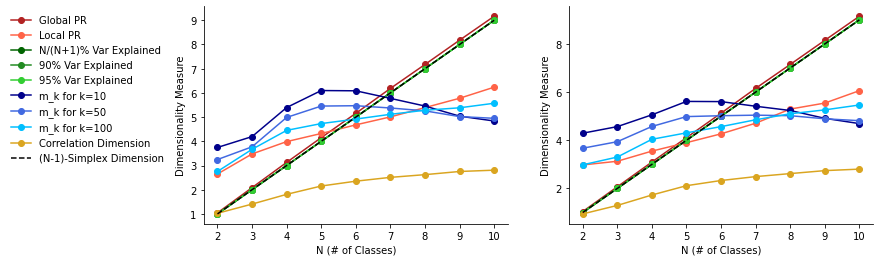

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121);
ax2 = fig.add_subplot(122);
k_vals = [10, 50, 100]

class_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]

colors = ['firebrick', 'tomato', 'darkgreen', 'forestgreen','limegreen', 'darkblue', 'royalblue', 'deepskyblue', 'goldenrod']

ax1.plot(class_sizes, prhs_avg, label='Global PR', marker='o', c=colors[0])
ax1.plot(class_sizes, local_prhs_avg, label='Local PR', marker='o', c=colors[1])
ax1.plot(class_sizes, ve_varhs_avg, label='N/(N+1)% Var Explained', marker='o', c=colors[2])
ax1.plot(class_sizes, ve_90hs_avg, label='90% Var Explained', marker='o', c=colors[3])
ax1.plot(class_sizes, ve_95hs_avg, label='95% Var Explained', marker='o', c=colors[4])
for k_val_idx in range(len(k_vals)):
  ax1.plot(class_sizes, mkhs_avg[:,k_val_idx], label='m_k for k='+str(k_vals[k_val_idx]), marker='o', c=colors[5+k_val_idx])
ax1.plot(class_sizes, cdhs_avg, label='Correlation Dimension', marker='o', c=colors[8])
# ax1.set_title('Hidden State Dimensionality')
ax1.set_xlabel('N (# of Classes)')
ax1.set_ylabel('Dimensionality Measure')
# ax1.legend()

ax2.plot(class_sizes, prfp_avg, label='Global PR', marker='o', c=colors[0])
ax2.plot(class_sizes, local_prfp_avg, label='Local PR', marker='o', c=colors[1])
ax2.plot(class_sizes, ve_varfp_avg, label='N/(N+1)% Var Explained', marker='o', c=colors[2])
ax2.plot(class_sizes, ve_90fp_avg, label='90% Var Explained', marker='o', c=colors[3])
ax2.plot(class_sizes, ve_95fp_avg, label='95% Var Explained', marker='o', c=colors[4])
for k_val_idx in range(len(k_vals)):
  ax2.plot(class_sizes, mkfp_avg[:,k_val_idx], label='m_k for k='+str(k_vals[k_val_idx]), marker='o', c=colors[5+k_val_idx])
ax2.plot(class_sizes, cdfp_avg, label='Correlation Dimension', marker='o', c=colors[8])
# ax2.set_title('Fixed Point Dimensionality')
ax2.set_xlabel('N (# of Classes)')
ax2.set_ylabel('Dimensionality Measure')

all_axs = [ax1, ax2]
for axis in all_axs:
  axis.plot(class_sizes, [class_val-1 for class_val in class_sizes], c='k', linestyle='dashed', label='(N-1)-Simplex Dimension')
  axis.set_xlabel('N (# of Classes)')
  axis.set_ylabel('Dimensionality Measure')
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)

ax1.legend(bbox_to_anchor=(-.1, 1), loc='upper right', frameon=False)

#### Readout Measures

In [ ]:
from itertools import combinations 

def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x P vector
  For each of b's columns, finds the percentage of its magnitude which lies in 
  the subspace formed by the columns of A (its columnspace). Then averages these together
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
  b_proj = np.matmul(proj, b) # N x P martix

  norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

  return np.mean(norm_perc)

def ro_subspace(readout):
  readout = np.asarray(readout)
  ro_n = readout.shape[0]
  indices = [i for i in range(ro_n)]
  comb = combinations(indices, ro_n-1) # Gets all possible combinations
  n_comb = 0
  perc_vals = 0
  for subspace_idxs in list(comb): # For each combination
    n_comb += 1
    A_idxs = list(subspace_idxs)
    b_idxs = list(filter(lambda a: a not in list(subspace_idxs), indices))
    A = readout[A_idxs]
    b = readout[b_idxs] 
    perc_vals += subspace_perc(A.T, b.T)
  return 1/n_comb * perc_vals

In [ ]:
base_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/kyle_rnn_data/'

class_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]
l2_value = 5e-4
trials = 10

ro_mags = []
ro_angles = []
ro_subspace_perc = []

for class_idx in range(len(class_sizes)):
  ro_mags_class = []
  ro_angles_class = []
  ro_subspace_perc_class = []
  for trial in range(trials):

    my_path = base_path + 'gru_{}class_uniformscore_noRO_l2is{}_{}_test.pickle'.format(class_sizes[class_idx], l2_value, trial)
    
    with open(my_path, 'rb') as load_file:
        params_loaded = pickle.load(load_file)
        toy_params = pickle.load(load_file)
        rnn_specs = pickle.load(load_file)
        train_params = pickle.load(load_file)

    rnn_params, readout_params = params_loaded
    readout = readout_params.T

    for i in range(len(readout)):
      ro_mags_class.append(np.linalg.norm(readout[i]))
    for i in range(len(readout)):
      for j in range(i):
        ro_angles_class.append(180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(np.linalg.norm(readout[i])*np.linalg.norm(readout[j]))))

    ro_subspace_perc_class.append(ro_subspace(readout))

  ro_mags.append(ro_mags_class)
  ro_angles.append(ro_angles_class)
  ro_subspace_perc.append(ro_subspace_perc_class)

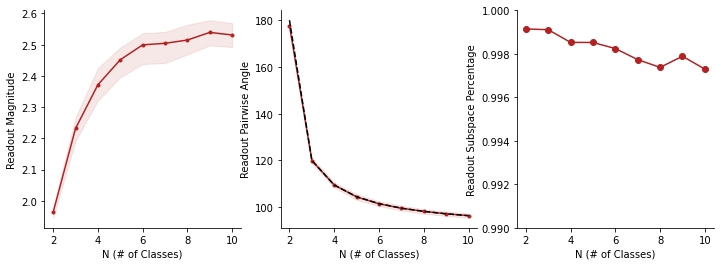

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

rom_medians = np.zeros((len(class_sizes)))
rom_upper = np.zeros((len(class_sizes)))
rom_lower = np.zeros((len(class_sizes)))

roa_medians = np.zeros((len(class_sizes)))
roa_upper = np.zeros((len(class_sizes)))
roa_lower = np.zeros((len(class_sizes)))

for class_idx in range(len(class_sizes)):
  rom_medians[class_idx] = np.median(ro_mags[class_idx])
  rom_upper[class_idx] = np.percentile(ro_mags[class_idx], 90)
  rom_lower[class_idx] = np.percentile(ro_mags[class_idx], 10)
  roa_medians[class_idx] = np.median(ro_angles[class_idx])
  roa_upper[class_idx] = np.percentile(ro_angles[class_idx], 90)
  roa_lower[class_idx] = np.percentile(ro_angles[class_idx], 10)
# for class_idx in range(len(class_sizes)):
#   class_size_array = [class_sizes[class_idx] for _ in range(len(ro_mags[class_idx]))]
#   ax1.scatter(class_size_array, ro_mags[class_idx])
ax1.fill_between(class_sizes, rom_lower, rom_upper, alpha=0.1, color='firebrick')
ax1.plot(class_sizes, rom_medians, color='firebrick', marker='.')
ax1.set_ylabel('Readout Magnitude')
# ax1.set_ylim((0,3))

roa_theory = [180/np.pi * np.arccos(-1/(class_num-1)) for class_num in class_sizes]

ax2.fill_between(class_sizes, roa_lower, roa_upper, alpha=0.1, color='firebrick')
ax2.plot(class_sizes, roa_medians, color='firebrick', marker='.')
ax2.plot(class_sizes, roa_theory, c='k', linestyle='dashed')
ax2.set_ylabel('Readout Pairwise Angle')

subspace_perc_avg = np.zeros((len(class_sizes)))
for class_idx in range(len(class_sizes)):
  subspace_perc_avg[class_idx] = np.mean(ro_subspace_perc[class_idx])
ax3.plot(class_sizes, subspace_perc_avg, c='firebrick', marker='o')
ax3.set_ylim((0.99, 1.0))
ax3.set_ylabel('Readout Subspace Percentage')

all_axs = [ax1, ax2, ax3]
for axis in all_axs:
  axis.set_xlabel('N (# of Classes)')
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)

### Contrived Ordered Example

In [7]:
syn.n_scores(5, 20)

53130.0

In [28]:
toy_params = {
  'phrase_length': 20,
  'loss_type': 'XE',
  'variable_length': False, # Takes max phrase length as phrase length
  'words': ['awesome', 'good', 'bad', 'awful', 'okay', 'the'],
  'uniform_score': True, # Uniform distribution over scores
  'unordered_class': False,
  # 'score_vals': [-2, -1, 1, 2, 0],
  'score_vals': [np.asarray([2, -1]), np.asarray([2, 1]), np.asarray([0, 2]), np.asarray([-2, 1]), np.asarray([-2, -1])],
  'outer_prod': False,
  'five_order_match': True
}

n_examples = 100
toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']

syn_data = syn.generate_data(n_examples, toy_params, len(toy_params['sentiments']), auto_balance=True, jnp_arrays=False)

Generating score map for uniform scores...
Looking for num per class: [20. 20. 20. 20. 20.]
Three score (6.0, 23.0)
Three score (20.0, 26.0)
Three score (12.0, 12.0)
Three score (-20.0, 30.0)
Three score (20.0, 20.0)
Three score (-10.0, 13.0)
Three score (14.0, 15.0)
Three score (-10.0, 29.0)
Three score (-4.0, 16.0)
Three score (-6.0, 7.0)
Three score (6.0, 21.0)
Three score (2.0, 21.0)
Three score (-10.0, 23.0)
Three score (-6.0, 33.0)
Three score (2.0, 33.0)
Three score (2.0, 11.0)
Three score (-12.0, 18.0)
Three score (22.0, 23.0)
Three score (-12.0, 34.0)
Three score (10.0, 23.0)
Three score (-8.0, 16.0)
Sythentic data generated in: 0.12 sec. Autobalanced: True. Uniform score: True


In [27]:
score_map

{(-4.0, -2.0): [2],
 (-4.0, 0.0): [4],
 (-4.0, 2.0): [5],
 (-2.0, -1.0): [1],
 (-2.0, 1.0): [3, 7],
 (-2.0, 3.0): [8],
 (0.0, -2.0): [16],
 (0.0, 0.0): [0, 11, 17],
 (0.0, 2.0): [6, 12],
 (0.0, 4.0): [9],
 (2.0, -1.0): [15],
 (2.0, 1.0): [10, 18],
 (2.0, 3.0): [13],
 (4.0, -2.0): [20],
 (4.0, 0.0): [19],
 (4.0, 2.0): [14]}

In [32]:
# First value is sentiment, second is neutrality
score_vals = [np.asarray([2, -1]), np.asarray([1, 1]), np.asarray([0, 1]), np.asarray([-1, 1]), np.asarray([2, -1])]

raw_count = (5, 3, 2, 4, 1)

tuple(np.dot(raw_count, toy_params['score_vals']))

(6, 5)